# 3 Sentiment analysis

For the sentiment analysis of the Amazon Fine Foods Review dataset I use pretrained bidirectional transformer [BERT](https://huggingface.co/transformers/model_doc/bert.html). The model was fine tuned using 80% training subset of the dataset. Th rest 20% validation subset will be used for the sentiment analysis, since it is relatively large (almost 79k samples). The validation subset has not used for the training steps and will not introduce train/serve skew due to possible overfitting.

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import seaborn as sns

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn import metrics

sns.set(font_scale=2)
plt.style.use('seaborn-white')
%matplotlib inline

In [ ]:
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels= 5)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [2]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


## 3.1 Reproducing Validation set
The data analysis performed for the current project will use only validation subset of the initial dataset.
The validation subset with over 75k rows is large enough for general analysis of the dataset.
Since it has not been used neither for model training nor for tuning the model meta parameters,
it should give results similar to real serving case. I split the dataset into train (80% samples) and validation (20%) sets exactly the same way as it have been don in the training step: 

Loading clean and deduplicated dataset:

In [38]:
df_dedup = pd.read_csv("./ReviewsDedupLowNT.csv.zip",
                       compression="zip", index_col=0)

Transform review score to 0-based: from 1-5 stars to 0-4 label and rename column for clarity:

In [39]:
df_dedup["Score"] = df_dedup["Score"] - 1
df_dedup.rename(columns={"Score": "Label"}, inplace=True)
df_dedup.tail(5)

,Text,Summary,Label,HelpfulnessNumerator,HelpfulnessDenominator
394998,these are sooooooooooooooooooooooooo delicious...,"yummy. yummy, yummy!",4,0,3
394999,this is a for the price of review because p...,pure chocolate mallomars cookies,3,0,0
395000,this would be a great coffee drink to grab out...,soso espresso style coffee drink,2,1,2
395001,"earths best infant formula soy iron,ounce is a...",earths best soy baby formula,4,0,0
395002,taste. i was expecting it to taste pretty clos...,ehh okay i guess.,1,1,1


In [40]:
df_train = df_dedup.sample(frac=0.8,random_state=123)
df_test = df_dedup.drop(df_train.index)

## 3.2 Score prediction

Now using the trained model I can make *Score* predictions and analyze initial review data.
For serving the model the weights for trained model are read from file:

In [6]:
model.load_weights("./amazon_my_trained_FL_G_e3x3vac77")

### 3.1.1 *Score* prediction based on review *Text*

First the review scores will be predicted based on review texts.
For efficient batch serving of the BERT model the dataset samples should be converted to the *InputExample* objects, containing

- *guid* - unique id for the example (not used)
- *text_a* (string) - the untokenized text of the first sequence
- *text_b* (optional, string) - the untokenized text of the second sequence (not used)
- label (optional, int) - The label of the example

and assembled to the TensorFlow datasets the same way as it was done on the training stage:

In [7]:
def convert_data_to_examples(df_input, data_column, label_column):
    input_examples = df_input.apply(lambda x:
                                    InputExample(guid=None,
                                                 text_a=x[data_column],
                                                 text_b=None,
                                                 label=x[label_column]),
                                    axis=1)
    return input_examples


def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = []
    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,  # Adds [CLS] and [SEP].
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            padding="max_length",
            truncation=True)
        input_ids, token_type_ids, attention_mask = (
            input_dict["input_ids"], input_dict["token_type_ids"],
            input_dict['attention_mask'])
        features.append(InputFeatures(
            input_ids=input_ids, attention_mask=attention_mask,
            token_type_ids=token_type_ids, label=e.label))

    def gen():
        for f in features:
            yield ({
                "input_ids": f.input_ids,
                "attention_mask": f.attention_mask,
                "token_type_ids": f.token_type_ids, },
                f.label, )
    return tf.data.Dataset.from_generator(
        gen, ({
            "input_ids": tf.int32,
            "attention_mask": tf.int32,
            "token_type_ids": tf.int32},
            tf.int64),
        ({
            "input_ids": tf.TensorShape([None]),
            "attention_mask": tf.TensorShape([None]),
            "token_type_ids": tf.TensorShape([None]), },
            tf.TensorShape([]), ), )

The following code chunk used for validation set tokenization and the batch prediction on the Google Colab GPU runtime: 

The prediction results are read from file:

In [5]:
text_predictions = pd.read_csv("./PredVa79ke3x3.csv.zip",
                               index_col=0, compression="zip")

Functions for accuracy calculation and visualization of confusion matrix:

In [72]:
LABELS = ['Very Negative','Negative','Neutral','Positive','Very Positive']


def accuracy_print(conf_matrix):
    values = conf_matrix.view()
    error_count = values.sum() - np.trace(values)
    accuracy = 1.0 - error_count/len(df_test["Label"])
    print("accuracy for {0}-element subset is {1}.".format(
        len(df_test["Label"]), accuracy))
    
    
def plot_conf_mat(conf_matrix, title, xlabel, ylabel):
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, norm=clrs.LogNorm(), xticklabels=LABELS,
    yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
    plt.title(title, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()

The confusion matrix for *Score* prediction based on review *Text* for entire validation set is following:

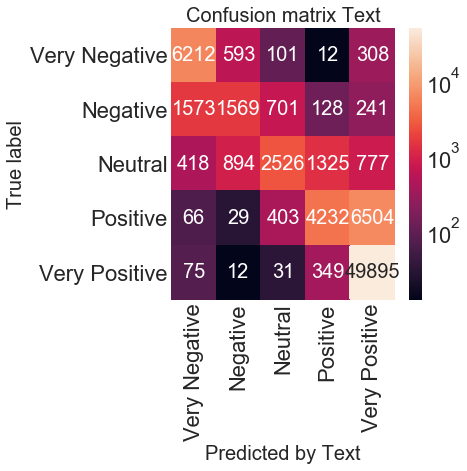

accuracy for 78974-element subset is 0.8158887735203991.


In [11]:
confusion_matrix = metrics.confusion_matrix(df_test["Label"], text_predictions)
plot_conf_mat(confusion_matrix, "Confusion matrix Text",
              "Predicted by Text", "True label")
accuracy_print(confusion_matrix)

One can see that majority of misclassified elements have neighboring score.
However a substantial number of *Very Negative* samples were missclassified as *Very Positive*.
Let's take a look at these samples:

In [42]:
df_test.reset_index(inplace=True)

In [80]:
bad_as_good = df_test["Text"][
    (text_predictions["0"]==4)&(df_test["Label"]==0)].tolist()

In [64]:
bad_as_good[0]

'my family have been gluten free for  years now. i also work in the natural products industry at the senior level and have seen the deception first hand. gluten is quite a serious issue as when it is consumed the villi are inpaired and other nutrients needed to be assimilated for other necessary body functions are not absorbed. it has caused my family other serious complications from eyesight to teeth and mouth difficulties and it has to stop. i am writing this reveiw because i am tired of feeling powerless while companies are prospering at the expense of our health. i follow a paleolithic diet for the most part and recently for my birthday decided to have a turkey sandwich on udis bagels. well they are most certainly not gluten free. even if less than ppm still makes someone sick. my entire mouth broke out in canker sores and i got a white spot on my front tooth that has not gone away because the gluten sensitivity is preventing iron absorption. udis is making millions of dollars and 

In [65]:
bad_as_good[1]

' shipping. each.price at local lucky market. each, no tax.i like this one primarily for the kick it gets from the tiny little packet of chili oil thats included.safeway tends to replace this soup with its inferior house brand about half the bite of the chili oil.they sell it at half the price, but if its not what you want, its not a bargain.is it?so i do want to stress that this is a superior, star product.i love it, i eat it almost daily, i make special trips to buy it, and i often empty lucks shelves, then go back after theyve restocked. i am selfemployed, i work from home, and many times this has filled the hole till i can finish what im doing and cook a more substantial meal.it is somewhat healthier than the standard ramen  cup o noodles product. grams fat  daily allowance, sat fat. grams, trans fat  grams, sodium.so maybe a healthier option is to eat all of the noodles but leave some of the broth.i just cant, in good conscience, encourage you to pay almost double the cost of what

In [66]:
bad_as_good[3]

' for a tin of earl grey, even if its ahmad my favorite? i buy excellent loose ahmad tea for around. so pray tell me what justifies this price? and ive smelled  not drunk  rare chinese tea that was going for  grams. i await enlightenment.'

In [68]:
bad_as_good[307]

'this is a great product, but these bottles retail for about  each at your local whole foodsnew seasons store!'

The reviews either contains positive sentiment not  related to the item, or the review sentiment itself is very positive apart one negative point concerning price.

### 3.1.2 *Score* prediction based on review *Summary*

The batch prediction for *Score* using *Summary* as an input can be done the same way as it was shown above for the *Text*. The following code chunk used for validation set tokenization and the batch prediction on the Google Colab GPU runtime:

The prediction results are read from file:

In [70]:
sum_predictions = pd.read_csv("./PredSumVa79ke3x3.csv.zip", index_col=0, compression="zip")

The confusion matrix for *Score* prediction based on review *Summary* for entire validation set is following:

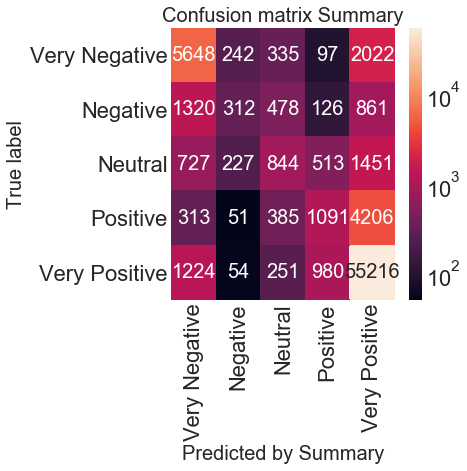

accuracy for 78974-element subset is 0.799136424646086.


In [76]:
confusion_matrix_sum = metrics.confusion_matrix(text_predictions,
                                                sum_predictions)
plot_conf_mat(confusion_matrix_sum, "Confusion matrix Summary",
              "Predicted by Summary", "True label")
accuracy_print(confusion_matrix_sum)

The overall model precision is slightly lower comparing to the previous *Text*-based case, but the model behavior is qualitatively same.

## 3.2 Sentiment correlation between review summary and text 

Now let's plot confusion matrix between prediction results based on *Text* and *Summary* of the reviews validation set. This matrix shows the sentiment correlation between summary and text of the review obtained by the model:

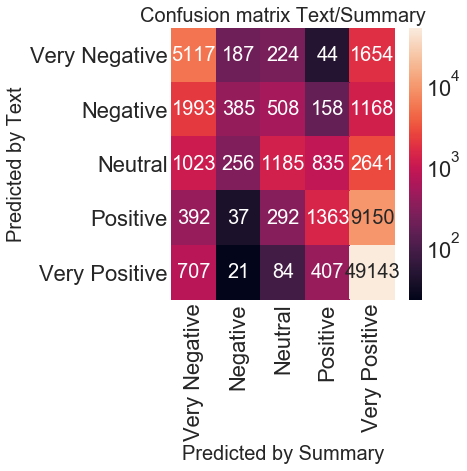

accuracy for 78974-element subset is 0.7242003697419404.


In [77]:
confusion_matrix_sum_text = metrics.confusion_matrix(df_test["Label"],
                                                     sum_predictions)
plot_conf_mat(confusion_matrix_sum_text, "Confusion matrix Text/Summary",
              "Predicted by Summary", "Predicted by Text")
accuracy_print(confusion_matrix_sum_text)

The sentiment of *Summary* and *Text* is generally aligned. Let's inspect the cases the samples with extreme missalignment:

In [89]:
def print_text_sum_pred(text_pred, sum_pred, index):
    """ Prints Text, Summary and Label of the sample
    with given labels predicted by Text and Summary
    (text_pred, sum_pred) and consecutive number index. 
    """
    df_cmp = df_test[["Text", "Summary", "Label"]][
    (text_predictions["0"]==text_pred)&(sum_predictions["0"]==sum_pred)]
    print(df_cmp.iloc[[index]]["Text"].tolist(), 
          df_cmp.iloc[[index]]["Summary"].tolist(), 
          df_cmp.iloc[[index]]["Label"])

In [90]:
print_text_sum_pred(0, 4, 2)

['peculiar taste did not like the taste of this water at all. it tastes like some kind of chemical. very strange flavor.'] ['flavor'] 35    0
Name: Label, dtype: int64


In [91]:
print_text_sum_pred(0, 4, 4)

['someone gave me a senseo machine, so i bought this coffee.  im very disappointed with the taste!  its bland and dull tasting.  too bad, as i have  bags now!this was my previous review.  since then, i gave away the senseo machine, but i kept the coffee and use it in a cup of hot water i do in the microwave.  the coffee is actually good.  i guess somehow the machine flavored it.  maybe its because the water doesnt sit in the coffee for long enough.  using my microwave method, i let the coffee bag brew awhile before pressing it and removing it  very good taste.  go figure!  anyway, id recommend this coffee as microwavable bags.'] ['disappointed, then happy'] 46    3
Name: Label, dtype: int64


In [92]:
print_text_sum_pred(4, 0, 2)

[' shipping?  making it. for a product you can buy in a store for.  why doesnt the seller sell by the box with a decent shipping rate and it would be worth purchasing.'] ['ridiculous price'] 82    0
Name: Label, dtype: int64


In [93]:
print_text_sum_pred(4, 0, 4)

[' for one piece as of sept  can only be an error, i hope. i love this product but usually get mine in germany for like. per piece. i hope this gets corrected soon.'] ['  you got to be kidding'] 88    4
Name: Label, dtype: int64


The examples above shows that Summary and Text missalignment appears usually if one of the fields (Text or Summary) is very hard to classify due to lack of useful tokens in very short summary or excessive size of the review Text, containing sentences with various sentiment.